<a href="https://colab.research.google.com/github/prxmitik/Quant/blob/main/Copy_of_Copy_of_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Momentum

Momentum-based Trading is based on the assumption that Stocks which have performed will in the past, will perform better in the coming future.

To define 'past', we take a variable **N**, and say that :

<centre> Momentum(For A particular stock) = Close Price(Today) - Close Price(N-day ago) </centre>

This gives us our first hyper-parameter (parameters of the model which could be changed in order to improve the model) : **N**

We would also be reshuffling our [Portfolio](https://www.investopedia.com/terms/p/portfolio.asp) at certain intervals of time, which gives us our second hyper-parameter: **T** (The time after which we'll be reshuffling our Portfolio)

Its never suggested to keep all your money invested, you must have some risk-free assets as well, so that even if you lose some of your cash in trading, you could still place better bets and regain that lost cash, Thus, We get our third Hyper-parameter: **R**, The Ratio of Total Balance, which we will using for investing.

You will not be investing in all the 30 Tickers now, Will you? You will choose the top few stocks, which show the highest promise in terms of Momentum, which brings us to another hyper-parameter: **M**, The Number of Top few stocks (based on Momentum), which you'll keep in your Portfolio.

Finally, There's some brokerage fee which you need to pay in order to place orders on the stock market, typically its less than 0.05% of the total amount : **F**


In [ ]:
from google.colab import files


uploaded = files.upload()

Saving DATA.csv to DATA.csv


In [ ]:

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns


N = 50
T = 7
R = 0.8
M = 5
F = 0.0005

The Second step would be to define a function which reads the Prices of various Stocks into memory.

In the file DATA.csv , which we had uploaded in our repository, we have prices of 30 firms enlisted in S & P 500 Index (Apple, IBM, Cisco, Walmart and the like!) from 2nd January 2009 to 17th August 2020.

For our purposes, We'll only be requiring certain columns. On an honest note, Just getting the Columns on Ticker, Date and Adjusted Closing Price would do the job, but if you want, you may take Opening Price as well.

Read up about the [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function from here, and figure out how you'll use it to do the job (You don't need all the columns!)

In [ ]:
def read_stock_prices(csv_file_path):
    try:

        df = pd.read_csv(DATA.csv)

        df['datadate'] = pd.to_datetime(df['datadate'])


        df.set_index('datadate', inplace=True)

        return df

    except Exception as e:
        print(f"Error occurred while reading the CSV file: {e}")
        return None


To aid Data-Manipulation, it would be beneficial, if we split the DataFrame into many small parts each corresponding to the data corresponding to the 30 Tickers on a particular date. These small parts could then be stored in a list.

We would also be needing to remember which date is at what index, so that we can use that later.

In [ ]:
import pandas as pd

def read_stock_prices(csv_file_path):
    try:

        df = pd.read_csv(csv_file_path)


        df['datadate'] = pd.to_datetime(df['datadate'])


        df.set_index('datadate', inplace=True)

        return df

    except Exception as e:
        print(f"Error occurred while reading the CSV file: {e}")
        return None

def PartitionData(Data):
    if Data is None:
        return [], {}

    grouped_data = Data.groupby('datadate')

    data_parts_list = []

    date_index_map = {}

    for index, (date, group) in enumerate(grouped_data):

        data_parts_list.append(group)


        date_index_map[date] = index

    return data_parts_list, date_index_map

stock_prices_df = read_stock_prices('DATA.csv')

if stock_prices_df is not None:
    data_parts_list, date_index_map = PartitionData(stock_prices_df)
else:
    data_parts_list = []
    date_index_map = {}


Now, We need a function to calculate the Momentum value for all of our 30 Tickers.
To do this, We need to have a few things in mind:


1.   We need to start at Nth day in our list, as only then we'll be able to calculate the Momentum (This will be taken care of by later parts of the Program, when we actually run the Model)

2.   The Stock Market isn't open on all days, so we often won't be able to go N days behind, and will have to take the closest value instead(We can't just go N entries behind in the List we created and expect that to work, Why?) In order to work with dates, you should get to know more about the datetime library of Python from [here](https://thispointer.com/python-how-to-convert-datetime-object-to-string-using-datetime-strftime/) (Especially the datetime.strftime() function) and about the [datetime.timedelta()](https://www.studytonight.com/python-howtos/how-to-add-days-to-date-in-python) function.

Also, as you may have figured it out yourself, while DataFrames are great for Data Handling and small statistical calculations, They aren't so for big calculations as the Numpy Library has both a richer variety of functions for such manipulations and is also more efficient!

After we calculate the Momentum for all our Tickers, it would be a great thing to do, if we could divide their prices by their mean(in the N day interval, as we need to see which stock outperforms others and in order to do this, it won't be fair if we take the absolute growth in numbers!(Why?)



In [ ]:
import numpy as np

def calculate_momentum(ticker_data, N, price_column_name='adjcp'):
    price_changes = np.diff(ticker_data[price_column_name], N)

    nan_array = np.empty(N-1)
    nan_array[:] = np.nan

    price_changes_with_nan = np.concatenate((nan_array, price_changes))
    adjcp_values = ticker_data['adjcp'].values

    available_data_length = len(adjcp_values)

    if available_data_length >= N:
        momentum = (price_changes_with_nan[:available_data_length-N+1] / adjcp_values[:available_data_length-N+1]) * 100
    else:
        momentum = np.nan

    return momentum

def calculate_momentum_for_all_tickers(data_parts_list, N):

    ticker_momentum_dict = {}

    for ticker_data in data_parts_list:

        momentum = calculate_momentum(ticker_data, N)

        ticker_name = ticker_data['tic'].iloc[0]
        ticker_momentum_dict[ticker_name] = momentum

    return ticker_momentum_dict

N = 5

ticker_momentum_dict = calculate_momentum_for_all_tickers(data_parts_list, N)






Even after you have got your Momentum-based priorities, and have decided which stocks to buy and what will be the weight of each, you still need to figure out how much of each will you buy. To do this, first you'll sell all your pre-owned stocks which will increase your cash in hand, then you'll know the stocks to buy and their relative weights (given by their Momentum/mean) and you need a function which tells you how many stocks to buy for each ticker!

In [ ]:
def calculate_stock_quantities(cash_in_hand, stock_prices, ticker_weights):
    """
    Calculate the number of shares to buy for each ticker based on their relative weights.

    Parameters:
        cash_in_hand (float): Current cash in hand available for investment.
        stock_prices (dict): Dictionary containing ticker names as keys and their respective stock prices as values.
        ticker_weights (dict): Dictionary containing ticker names as keys and their relative weights as values.

    Returns:
        dict: A dictionary containing ticker names as keys and the number of shares to buy for each ticker as values.
    """
    total_investment = cash_in_hand

    total_weight = sum(ticker_weights.values())

    stock_quantities = {}

    for ticker, weight in ticker_weights.items():
        target_investment = total_investment * (weight / total_weight)

        num_shares_to_buy = target_investment / stock_prices[ticker]

        stock_quantities[ticker] = num_shares_to_buy

    return stock_quantities



Now, We need something to simulate our [Portfolio](https://www.investopedia.com/terms/p/portfolio.asp). In order to do that we need a class, which has certain  basic features and functionalities.

Features :


1.   Your Initial Balance
2.   Your Current Balance
3.   A list(/any other container) storing the number of stocks of each ticker currently in possession. (Numpy Array prefered)
4.   Most recent prices of all the stocks (As a Numpy array)

Functionalities:



1.   Calculating current Net Worth (Balance+Total Evaluation of all Stocks owned!)
2.   Buying a Particular Stock (Keep the Transaction fee in mind!)
3.   Selling a particular Stock whole (Keep the Transaction Fee in mind!)
4.   Rebalance Portfolio  (Takes Numpy array as input)
5.   Function to change the value of most recent prices stored (Takes Numpy array as input)





In [ ]:
import numpy as np

class Portfolio:
    def __init__(self, initial_balance, ticker_symbols, stock_prices, transaction_fee=0):
        self.initial_balance = initial_balance
        self.current_balance = initial_balance
        self.ticker_symbols = ticker_symbols
        self.num_stocks_owned = np.zeros(len(ticker_symbols), dtype=int)
        self.stock_prices = stock_prices
        self.transaction_fee = transaction_fee

    def calculate_net_worth(self):
        stock_value = np.sum(self.num_stocks_owned * self.stock_prices)

        net_worth = self.current_balance + stock_value

        return net_worth

    def buy_stock(self, ticker_index, num_shares):
        total_cost = (self.stock_prices[ticker_index] * num_shares) * (1 + self.transaction_fee)

        if self.current_balance >= total_cost:
            self.num_stocks_owned[ticker_index] += num_shares
            self.current_balance -= total_cost
            print(f"Bought {num_shares} shares of {self.ticker_symbols[ticker_index]} successfully.")
        else:
            print("Insufficient balance to make the purchase.")

    def sell_stock(self, ticker_index, num_shares):
        if self.num_stocks_owned[ticker_index] >= num_shares:
            total_earnings = (self.stock_prices[ticker_index] * num_shares) * (1 - self.transaction_fee)

            self.num_stocks_owned[ticker_index] -= num_shares
            self.current_balance += total_earnings
            print(f"Sold {num_shares} shares of {self.ticker_symbols[ticker_index]} successfully.")
        else:
            print("Insufficient stocks to make the sale.")

    def rebalance_portfolio(self, target_weights):
        total_investment = self.current_balance

        target_weights_normalized = target_weights / np.sum(target_weights)

        target_investments = total_investment * target_weights_normalized

        target_stock_quantities = np.floor(target_investments / self.stock_prices)

        stock_quantity_diff = target_stock_quantities - self.num_stocks_owned

        for i, diff in enumerate(stock_quantity_diff):
            if diff > 0:
                self.buy_stock(i, int(diff))
            elif diff < 0:
                self.sell_stock(i, int(-diff))

    def update_stock_prices(self, new_stock_prices):
        self.stock_prices = new_stock_prices







With that the difficult part is over!

Now, all you need to work on is a main loop, which calls all these functions

In [ ]:
def main():
    ticker_symbols = np.array(['AAPL', 'GOOGL', 'MSFT', 'AMZN'])
    stock_prices = np.array([150.0, 2700.0, 300.0, 3500.0])
    transaction_fee = 0.01
    initial_balance = 10000.0

    portfolio = Portfolio(initial_balance, ticker_symbols, stock_prices, transaction_fee)

    while True:
        print("\n--- Portfolio Management Menu ---")
        print("1. View Current Net Worth")
        print("2. Buy Stock")
        print("3. Sell Stock")
        print("4. Rebalance Portfolio")
        print("5. Update Stock Prices")
        print("6. Exit")

        choice = int(input("Enter your choice (1-6): "))

        if choice == 1:
            net_worth = portfolio.calculate_net_worth()
            print(f"Current Net Worth: {net_worth}")
        elif choice == 2:
            ticker_index = int(input("Enter the index of the ticker to buy: "))
            num_shares = int(input("Enter the number of shares to buy: "))
            portfolio.buy_stock(ticker_index, num_shares)
        elif choice == 3:
            ticker_index = int(input("Enter the index of the ticker to sell: "))
            num_shares = int(input("Enter the number of shares to sell: "))
            portfolio.sell_stock(ticker_index, num_shares)
        elif choice == 4:
            target_weights = np.array(input("Enter the target weights for rebalancing (separated by spaces): ").split(), dtype=float)
            portfolio.rebalance_portfolio(target_weights)
        elif choice == 5:
            new_stock_prices = np.array(input("Enter the updated stock prices (separated by spaces): ").split(), dtype=float)
            portfolio.update_stock_prices(new_stock_prices)
        elif choice == 6:
            print("Exiting the portfolio management system.")
            break
        else:
            print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main()








--- Portfolio Management Menu ---
1. View Current Net Worth
2. Buy Stock
3. Sell Stock
4. Rebalance Portfolio
5. Update Stock Prices
6. Exit
Enter your choice (1-6): 2
Enter the index of the ticker to buy: 3
Enter the number of shares to buy: 4
Insufficient balance to make the purchase.

--- Portfolio Management Menu ---
1. View Current Net Worth
2. Buy Stock
3. Sell Stock
4. Rebalance Portfolio
5. Update Stock Prices
6. Exit
Enter your choice (1-6): 1
Current Net Worth: 10000.0

--- Portfolio Management Menu ---
1. View Current Net Worth
2. Buy Stock
3. Sell Stock
4. Rebalance Portfolio
5. Update Stock Prices
6. Exit
Enter your choice (1-6): 6
Exiting the portfolio management system.


##Moment of Truth

Time to check, if your Program actually works!

Plot the data you collected in various ways and see if what you did worked!

Feel free to use whichever one of Matplotlib or Seaborn you want to.

You should try changing the hyper-parameters to increase(/decrease) your performance!


Insufficient balance to make the purchase.
Insufficient stocks to make the sale.
Insufficient stocks to make the sale.
Insufficient stocks to make the sale.
Insufficient stocks to make the sale.
Insufficient stocks to make the sale.
Insufficient stocks to make the sale.
Insufficient balance to make the purchase.
Insufficient stocks to make the sale.
Insufficient stocks to make the sale.
Insufficient stocks to make the sale.
Bought 3 shares of MSFT successfully.
Bought 7 shares of AAPL successfully.
Bought 2 shares of MSFT successfully.
Insufficient stocks to make the sale.
Bought 4 shares of AAPL successfully.
Bought 1 shares of GOOGL successfully.
Insufficient stocks to make the sale.
Insufficient stocks to make the sale.
Insufficient balance to make the purchase.
Insufficient balance to make the purchase.
Bought 7 shares of MSFT successfully.
Insufficient balance to make the purchase.
Sold 3 shares of MSFT successfully.
Sold 9 shares of MSFT successfully.
Insufficient balance to make

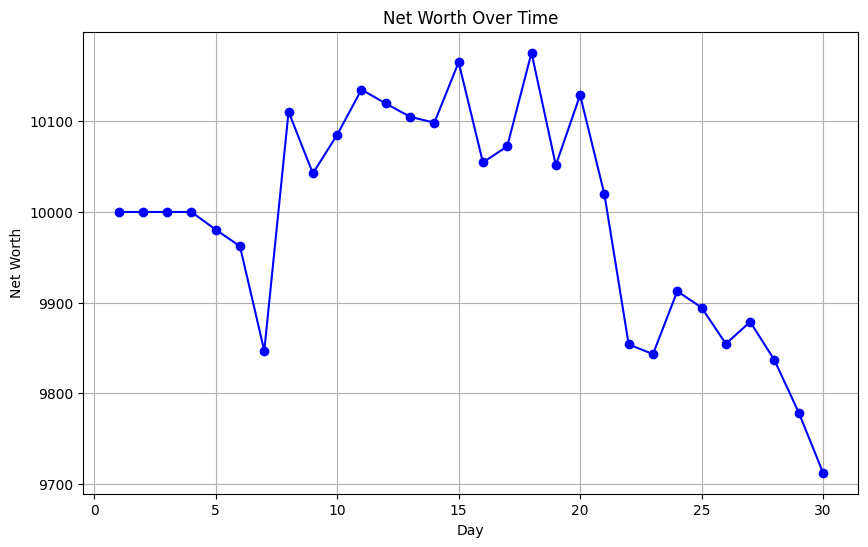

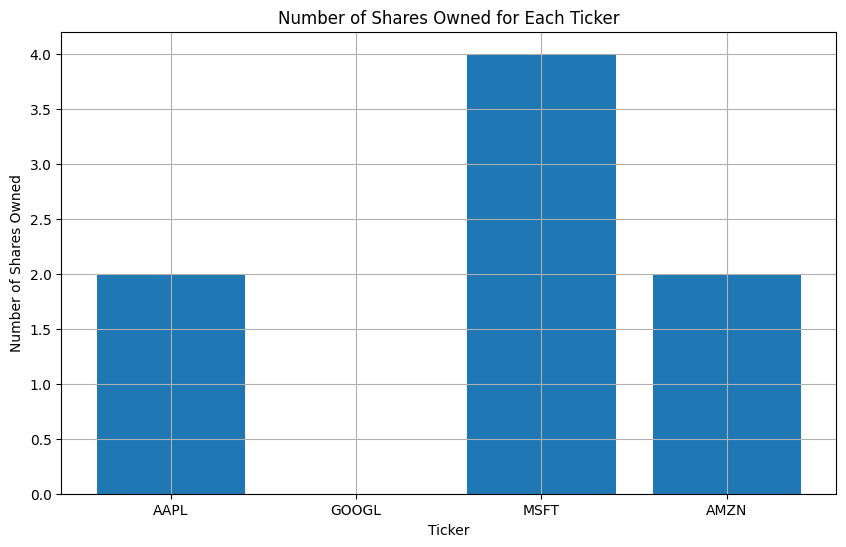

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def main():
    ticker_symbols = np.array(['AAPL', 'GOOGL', 'MSFT', 'AMZN'])
    initial_stock_prices = np.array([150.0, 2700.0, 300.0, 3500.0])
    transaction_fee = 0.01
    initial_balance = 10000.0

    portfolio = Portfolio(initial_balance, ticker_symbols, initial_stock_prices, transaction_fee)

    num_days = 30
    stock_prices_over_time = np.random.normal(loc=initial_stock_prices, scale=10, size=(num_days, len(ticker_symbols)))

    net_worth_over_time = []
    for day in range(num_days):
        portfolio.update_stock_prices(stock_prices_over_time[day])

        for _ in range(np.random.randint(1, 5)):
            ticker_index = np.random.randint(len(ticker_symbols))
            action = np.random.choice(['buy', 'sell'])
            num_shares = np.random.randint(1, 10)

            if action == 'buy':
                portfolio.buy_stock(ticker_index, num_shares)
            else:
                portfolio.sell_stock(ticker_index, num_shares)

        net_worth = portfolio.calculate_net_worth()
        net_worth_over_time.append(net_worth)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_days + 1), net_worth_over_time, marker='o', linestyle='-', color='b')
    plt.xlabel('Day')
    plt.ylabel('Net Worth')
    plt.title('Net Worth Over Time')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(ticker_symbols)), portfolio.num_stocks_owned)
    plt.xticks(np.arange(len(ticker_symbols)), ticker_symbols)
    plt.xlabel('Ticker')
    plt.ylabel('Number of Shares Owned')
    plt.title('Number of Shares Owned for Each Ticker')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()












You may use this cell to write about what results you got!